In [1]:
import logging
import os
import sys

sys.path.append('../')

from typing import List, Callable, NoReturn, NewType, Any
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

from retrieval import SparseRetrieval

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer

from arguments import (
    ModelArguments,
    DataTrainingArguments,
    LoggingArguments,
)

from custom_tokenizer import load_pretrained_tokenizer

from dotenv import load_dotenv
from preprocessor import Preprocessor

## Argument

In [2]:
model_args = ModelArguments
data_args = DataTrainingArguments
training_args = TrainingArguments

In [3]:
set_seed(training_args.seed)

## Datasets

In [4]:
datasets = load_from_disk('/opt/ml/data/train_dataset')

## Preprocessing

In [5]:
datasets.cleanup_cache_files()
datasets = Preprocessor.preprocessing(datasets, pt_num="13")

In [6]:
datasets['train'][0]

{'__index_level_0__': 42,
 'answers': {'answer_start': [229], 'text': ['하원']},
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다. 미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다. 미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'document_id': 18293,
 'id': 'mrc-1-000067',
 'q

## Tokenizer

In [7]:
model_args.model_name_or_path = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, use_fast=True)

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [8]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Wiki Data

In [9]:
import json

data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [10]:
wiki_data = []

for key in wiki.keys() :
    data = wiki[key]
    wiki_data.append(data['text'])

In [11]:
wiki_data = Preprocessor.preprocessing(wiki_data, pt_num = "13")

## Retrieval

In [12]:
from retrieval_bm25 import SparseRetrieval

In [13]:
retrieval_bm25 = SparseRetrieval(tokenize_fn=tokenizer.tokenize, contexts=wiki_data)

Context Length : 55963 


In [14]:
retrieval_bm25.get_sparse_BM25('./bm25', '13')

BM25 Embedding pickle ./bm25/BM25_embedding_13.bin loaded.


In [15]:
train_data = datasets['train']
#train_retrieval = retrieval_bm25.retrieve_BM25(train_data)

In [16]:
with open('./train_retrieval.json', "r", encoding="utf-8") as f:
    train_retrieval = json.load(f)

In [17]:
train_retrieval = pd.DataFrame(train_retrieval)
train_retrieval.head()

,question,id,context_id,context
0,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"[13725, 6031, 2269, 19333, 51552, 19752, 16322...",미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...
1,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"[47055, 47049, 47056, 47059, 47052, 47054, 470...",'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...
2,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"[474, 461, 470, 26650, 472, 34409, 11245, 466,...",강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...
3,11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"[33351, 40980, 30820, 36303, 31981, 49284, 399...","불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든..."
4,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"[42757, 15050, 54529, 18144, 20265, 49273, 421...",동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...


## Negative Sampling

In [18]:
num_neg = 3
train_size= len(train_data)

p_with_neg = []

for i in tqdm(range(len(train_retrieval))):
    data_idx = train_retrieval.iloc[i]
    question = data_idx['question']
    context = data_idx['context']

    similar_context_indices = data_idx['context_id']
    simiar_contexts = [wiki_data[i] for i in similar_context_indices if wiki_data[i] != context]

    p_with_neg.append(context)
    p_with_neg.extend(simiar_contexts[:num_neg])

In [19]:
print('Context Size with Negative Sampling : %d' %len(p_with_neg))

Context Size with Negative Sampling : 15808


In [20]:
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)

# questions
q_seqs = tokenizer(train_data['question'], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt')

# passages
p_seqs = tokenizer(p_with_neg, 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt')

In [21]:
max_len = p_seqs['input_ids'].size(-1)
p_seqs['input_ids'] = p_seqs['input_ids'].view(-1, num_neg+1, max_len)
p_seqs['attention_mask'] = p_seqs['attention_mask'].view(-1, num_neg+1, max_len)
p_seqs['token_type_ids'] = p_seqs['token_type_ids'].view(-1, num_neg+1, max_len)

In [22]:
print('Max Length : %d \n' %max_len)
print('Input Ids : {}'.format(p_seqs['input_ids'].shape))
print('Attention Mask : {}'.format(p_seqs['attention_mask'].shape))
print('Token Type Ids : {}'.format(p_seqs['token_type_ids'].shape))

Max Length : 512 

Input Ids : torch.Size([3952, 4, 512])
Attention Mask : torch.Size([3952, 4, 512])
Token Type Ids : torch.Size([3952, 4, 512])


## Datasets

In [23]:
# passage & question
train_dataset = TensorDataset(p_seqs['input_ids'], 
    p_seqs['attention_mask'], 
    p_seqs['token_type_ids'],            
    q_seqs['input_ids'], 
    q_seqs['attention_mask'], 
    q_seqs['token_type_ids'])

## Model

In [24]:
from transformers import BertPreTrainedModel, BertModel

In [25]:
class BertEncoder(BertPreTrainedModel):
    def __init__(self, config) :
        super(BertEncoder, self).__init__(config)
        self.bert = BertModel(config)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None): 
        outputs = self.bert(input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs[1]
        return pooled_output

## Training

In [26]:
import torch
import torch.nn.functional as F
from itertools import chain
from transformers import BertModel, BertPreTrainedModel, AdamW, TrainingArguments, get_linear_schedule_with_warmup

In [27]:
def progressLearning(value, endvalue, loss, bar_length=50):
    percent = float(value + 1) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r[{0}] {1}/{2} \t Loss : {3:.3f}".format(arrow + spaces, value+1, endvalue, loss))
    sys.stdout.flush()

In [28]:
def train(args, dataset, p_model, q_model) :
    train_sampler = RandomSampler(dataset)
    train_dataloader = DataLoader(dataset, 
        sampler=train_sampler, 
        batch_size=args.per_device_train_batch_size,
        drop_last=True)

    model_parameters = chain(p_model.parameters(), q_model.parameters())
    optimizer = AdamW(model_parameters, 
        lr=args.learning_rate, 
        weight_decay=args.weight_decay
    )

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
        num_warmup_steps=args.warmup_steps,
        num_training_steps=t_total)

    optimizer.zero_grad()
    p_model.zero_grad()
    q_model.zero_grad()

    global_step = 0
    min_loss = np.inf
    for i in range(int(args.num_train_epochs)) :
        q_model.train()
        p_model.train()

        step_idx = 0
        mean_loss = 0.0
        print('Epoch : %d' %i)
        for step, batch in enumerate(train_dataloader):
            targets = torch.zeros(args.per_device_train_batch_size).long()
            if torch.cuda.is_available():
                batch = tuple(t.cuda() for t in batch)
                targets = targets.cuda()

            p_inputs = {'input_ids': batch[0].view(args.per_device_train_batch_size*(num_neg+1), -1),
                'attention_mask': batch[1].view(args.per_device_train_batch_size*(num_neg+1), -1),
                'token_type_ids': batch[2].view(args.per_device_train_batch_size*(num_neg+1), -1)
            }
      
            q_inputs = {'input_ids': batch[3],
                'attention_mask': batch[4],
                'token_type_ids': batch[5]
            }

            p_outputs = p_model(**p_inputs)  # (batch_size * (num_neg+1), emb_dim)
            q_outputs = q_model(**q_inputs)  # (batch_size, emb_dim)

            p_outputs = p_outputs.view(args.per_device_train_batch_size, num_neg+1, -1) # (batch_size, num_neg+1, emb_dim)
            p_outputs = torch.transpose(p_outputs, 1, 2) # (batch_size, emb_dim, num_neg+1) 

            q_outputs = q_outputs.view(args.per_device_train_batch_size, 1, -1)

            # (batch_size, 1, emb_dim) * (batch_size, emb_dim, num_neg+1) -> (batch_size, 1, num_neg+1)
            sim_scores = torch.bmm(q_outputs, p_outputs).squeeze(1)  #(batch_size, num_neg+1)
            sim_scores = F.log_softmax(sim_scores, dim=1)

            loss = F.nll_loss(sim_scores, targets)
            progressLearning(step_idx, len(train_dataloader), loss.item())
            mean_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()
            p_model.zero_grad()
            q_model.zero_grad()
            step_idx += 1
            global_step += 1

        mean_loss /= len(train_dataloader)
        if mean_loss < min_loss :
            min_loss = loss 
            torch.save({'steps' : global_step,
                'p_encoder_state_dict' : p_model.state_dict() , 
                'q_decoder_state_dict' : q_model.state_dict() , 
                'loss' : loss.item() }, 
            os.path.join(args.output_dir, 'dense_encoder.pt'))    

        print('\nMean Loss : %.3f\n' %(mean_loss))
        
    return p_model, q_model


In [51]:
args = TrainingArguments(
    output_dir="./model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    num_train_epochs=10,
    warmup_steps=2000,
    weight_decay=1e-4
)

In [52]:
torch.cuda.empty_cache()

p_encoder = BertEncoder.from_pretrained(model_args.model_name_or_path) # passage encoder
q_encoder = BertEncoder.from_pretrained(model_args.model_name_or_path) # question encoder

if torch.cuda.is_available() :
    p_encoder.cuda()
    q_encoder.cuda()

In [34]:
p_encoder, q_encoder = train(args, train_dataset, p_encoder, q_encoder)

Epoch : 0
[------------------------------------------------->] 988/988 	 Loss : 1.130
Mean Loss : 4.097

Epoch : 1
[------------------------------------------------->] 988/988 	 Loss : 0.360
Mean Loss : 0.916

Epoch : 2
[------------------------------------------------->] 988/988 	 Loss : 0.349
Mean Loss : 0.628

Epoch : 3
[------------------------------------------------->] 988/988 	 Loss : 0.019
Mean Loss : 0.350

Epoch : 4
[------------------------------------------------->] 988/988 	 Loss : 0.007
Mean Loss : 0.136



## Similarity

In [35]:
val_data = datasets['validation']

In [36]:
test_query = val_data['question'][0]
test_context = val_data['context'][0]

In [37]:
print('Query : %s \n' %test_query)
print('Ground Truth Context : %s \n' %test_context)

Query : 처음으로 부실 경영인에 대한 보상 선고를 받은 회사는? 

Ground Truth Context : 순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법시험에 합격하여 판사로 임용되었고 대법원 재판연구관, 수원지법 부장판사, 사법연수원 교수, 특허법원 부장판사 등을 거쳐 능력을 인정받았다. 2003년 최종영 대법원장의 지명으로 헌법재판소 재판관을 역임하였다. 경제민주화위원회(위원장 장하성이 소액주주들을 대표해 한보철강 부실대출에 책임이 있는 이철수 전 제일은행장 등 임원 4명을 상대로 제기한 손해배상청구소송에서 서울지방법원 민사합의17부는 1998년 7월 24일에 "한보철강에 부실 대출하여 은행에 막대한 손해를 끼친 점이 인정된다"며 "원고가 배상을 청구한 400억원 전액을 은행에 배상하라"고 하면서 부실 경영인에 대한 최초의 배상 판결을 했다. 2004년 10월 신행정수도의건설을위한특별조치법 위헌 확인 소송에서 9인의 재판관 중 유일하게 각하 견해를 내었다. 소수의견에서 전효숙 재판관은 다수견해의 문제점을 지적하면서 관습헌법 법리를 부정하였다. 전효숙 재판관은 서울대학교 근대법학교육 백주년 기념관에서 열린 강연에서, 국회가 고도의 정치적인 사안을 정치로 풀기보다는 헌법재판소에 무조건 맡겨서 해결하려는 자세는 헌법재판소에게 부담스럽다며 소회를 밝힌 바 있다. 



In [38]:
q_val_seqs = tokenizer([test_query], 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt') # question

In [39]:
def make_wiki_embedding(p_model, tokenizer, wiki_data) :

    print('Tokenizing Wiki Corpus Data')
    p_wiki_seqs = tokenizer(wiki_data, 
        padding="max_length", 
        truncation=True, 
        return_tensors='pt'
    )

    p_embs = []

    print('Make Dense Embedding from Wiki Corpus Data')
    with torch.no_grad() :
        p_wiki_seqs = p_wiki_seqs.to('cuda')
        wiki_size = len(wiki_data)
        for i in tqdm(range(wiki_size)) :
            p_input_ids = p_wiki_seqs['input_ids'][i].unsqueeze(0)
            p_attention_mask = p_wiki_seqs['attention_mask'][i].unsqueeze(0)
            p_token_type_ids = p_wiki_seqs['token_type_ids'][i].unsqueeze(0)

            p_emb_tensor = p_model(input_ids = p_input_ids, 
                attention_mask = p_attention_mask, 
                token_type_ids = p_token_type_ids) # (1, hidden_size)

            p_embs.append(p_emb_tensor.to('cpu').numpy())        

        p_embs = torch.Tensor(p_embs).squeeze(1) # (wiki data size, hidden_size)
        p_embs = p_embs.detach().numpy() # torch tensor to numpy ndarray

    return p_embs

In [40]:
p_wiki_emb = make_wiki_embedding(p_encoder, tokenizer, wiki_data)

Tokenizing Wiki Corpus Data
Make Dense Embedding from Wiki Corpus Data


In [41]:
print('Wiki Embedding array Shape : %s' %str(p_wiki_emb.shape))

Wiki Embedding array Shape : (55963, 768)


In [42]:
def to_cuda(batch):
    return tuple(t.cuda() for t in batch)

In [43]:
def retrieve(q_model, query, p_embs, topK=10) :

    with torch.no_grad() :
        q_model.eval()
 
        q_tensor = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt').to('cuda')
        q_embs = q_model(**q_tensor).to('cpu').detach().numpy() # (1, hidden_size)

    sim_scores = np.matmul(q_embs, p_embs.T)[0]
    sim_scores_rank = np.argsort(sim_scores)[::-1]

    topk_wiki_index = list(sim_scores_rank[:topK])
    topk_sim_score = [sim_scores[i] for i in topk_wiki_index]
    return topk_sim_score, topk_wiki_index

In [44]:
test_sim_score, test_sim_indices = retrieve(q_encoder, test_query, p_wiki_emb)

In [45]:
print('Top 10 Wiki Contexts Indices from test Query')
print(test_sim_indices)

print('\nTop 10 Wiki Contexts Simiarlity Scores')
print(test_sim_score)

Top 10 Wiki Contexts Indices from test Query
[33506, 15297, 54787, 50780, 50280, 17281, 17962, 55513, 21760, 5771]

Top 10 Wiki Contexts Simiarlity Scores
[202.01935, 200.85886, 200.40208, 200.34744, 200.06953, 200.06041, 199.61172, 199.44212, 199.40868, 199.34052]


## Recall@K

In [46]:
import matplotlib.pyplot as plt
import collections

In [47]:
val_data = datasets['validation']

In [48]:
pos_data = []

for i in tqdm(range(len(val_data))) :
    query = val_data['question'][i]
    context = val_data['context'][i]

    topk_scores, topK_indices = retrieve(q_encoder, query, p_wiki_emb)
    topK_contexts = [wiki_data[j] for j in topK_indices]

    if context in topK_contexts :
        pos_data.append(topK_contexts.index(context))
    else :
        pos_data.append(-5)


In [49]:
def visualize(pos_data, name) :
    counter = collections.Counter()
    counter.update(pos_data)
    count_items = sorted(counter.items(), key = lambda x : x[0])

    plt.figure(figsize = (8,6))
    x_vals = [item[0] for item in count_items]
    y_vals = [item[1] for item in count_items]

    plt.bar(x_vals, y_vals, 0.75, color = "skyblue")
    plt.title(name, fontsize=15)
  
    for i in range(len(y_vals)):
        y_val = y_vals[i]
        x_val = x_vals[i]
        plt.text(x_val , y_val+3, str(y_val), 
            color = 'blue', fontweight = 'bold')
    plt.show()

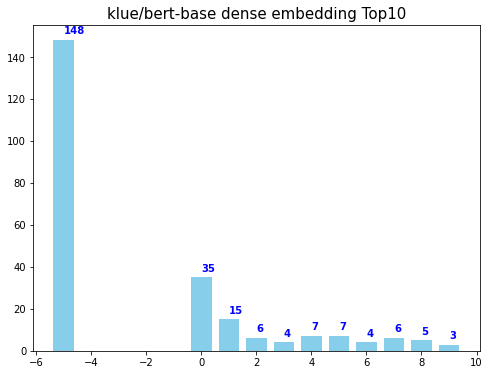

In [50]:
visualize(pos_data, 'klue/bert-base dense embedding Top10')